# 26f: Coverage vs Trump Count

**Claim**: Folk wisdom says "2 trumps + perfect coverage beats 4 trumps + naked lows"

**Null Hypothesis**: Trump count dominates (more trumps = better, regardless of coverage)

**Method**:
1. Build `coverage_score` feature that captures off-suit quality
2. Regress E[V] on trump_count + coverage_score
3. Compare standardized coefficients to determine relative importance

**Confirmed If**: coverage_score coefficient is comparable to or larger than trump_count

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"
DATA_DIR = "/mnt/d/shards-standard/train"

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
import statsmodels.api as sm

from forge.analysis.utils import viz
from forge.oracle import schema
from forge.oracle.rng import deal_from_seed

viz.setup_notebook_style()
np.random.seed(42)
print("Ready")

Ready


## 1. Define Coverage Score Feature

In [2]:
def domino_suits(d_id: int) -> set:
    """Return set of suits this domino belongs to."""
    pips = schema.domino_pips(d_id)
    if pips[0] == pips[1]:
        return {pips[0]}  # Doubles belong to one suit
    return {pips[0], pips[1]}

def domino_rank_in_suit(d_id: int, suit: int) -> int:
    """Return rank of domino in suit (higher = better).
    
    For non-doubles: the 'off pip' (pip not matching suit) is the rank.
    Higher off-pip = higher rank = better.
    For doubles: pip value is the rank.
    """
    pips = schema.domino_pips(d_id)
    if pips[0] == pips[1]:  # Double
        return pips[0]
    if pips[0] == suit:
        return pips[1]
    else:
        return pips[0]

def compute_coverage_score(hand: list, trump_suit: int = None) -> float:
    """Compute a coverage quality score for off-suits.
    
    Coverage score considers:
    - Depth in each off-suit (more = better)
    - Quality (rank) of holdings in each suit
    - Penalizes naked lows (singletons with rank <= 2)
    
    Returns a score where higher = better coverage.
    """
    # Build suit holdings
    suit_holdings = {s: [] for s in range(7)}
    for d in hand:
        for suit in domino_suits(d):
            suit_holdings[suit].append((d, domino_rank_in_suit(d, suit)))
    
    score = 0.0
    n_off_suits = 0
    
    for suit in range(7):
        # Skip trump suit (only 0-6 valid)
        if trump_suit is not None and suit == trump_suit and trump_suit < 7:
            continue
        
        holdings = suit_holdings[suit]
        depth = len(holdings)
        
        if depth == 0:  # Void - neutral (not necessarily bad)
            continue
        
        n_off_suits += 1
        
        # Get ranks in this suit
        ranks = [r for (d, r) in holdings]
        max_rank = max(ranks)
        min_rank = min(ranks)
        
        # Coverage score components:
        # 1. Depth bonus: +1 per domino beyond first
        depth_bonus = max(0, depth - 1)
        
        # 2. High card bonus: +1 if max_rank >= 5 (can win tricks)
        high_card_bonus = 1 if max_rank >= 5 else 0
        
        # 3. Naked low penalty: -2 if singleton with rank <= 2
        naked_low_penalty = -2 if (depth == 1 and max_rank <= 2) else 0
        
        score += depth_bonus + high_card_bonus + naked_low_penalty
    
    return score

# Test
test_hand = [0, 1, 2, 3, 4, 5, 6]  # 0-0, 1-0, 1-1, 2-0, 2-1, 2-2, 3-0
print(f"Test hand: {[f'{schema.domino_pips(d)}' for d in test_hand]}")
print(f"Coverage score (trump=0): {compute_coverage_score(test_hand, trump_suit=0):.1f}")
print(f"Coverage score (trump=6): {compute_coverage_score(test_hand, trump_suit=6):.1f}")

Test hand: ['(0, 0)', '(1, 0)', '(1, 1)', '(2, 0)', '(2, 1)', '(2, 2)', '(3, 0)']
Coverage score (trump=0): 2.0
Coverage score (trump=6): 5.0


## 2. Load Data and Compute Coverage Score

In [3]:
# Load unified features
features_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/12b_unified_features.csv"
df = pd.read_csv(features_path)

print(f"Loaded {len(df)} hands")
print(f"Trump count range: [{df['trump_count'].min()}, {df['trump_count'].max()}]")
print(f"E[V] range: [{df['V_mean'].min():.1f}, {df['V_mean'].max():.1f}]")

Loaded 200 hands
Trump count range: [0, 5]
E[V] range: [-29.3, 42.0]


In [4]:
# Compute coverage score for each hand
coverage_data = []

for _, row in df.iterrows():
    seed = int(row['base_seed'])
    trump = int(row['trump_suit'])
    
    hands = deal_from_seed(seed)
    p0_hand = hands[0]
    
    coverage_score = compute_coverage_score(p0_hand, trump_suit=trump)
    
    coverage_data.append({
        'base_seed': seed,
        'coverage_score': coverage_score,
    })

coverage_df = pd.DataFrame(coverage_data)

# Merge with main features
df = df.merge(coverage_df, on='base_seed')

print(f"Coverage score distribution:")
print(df['coverage_score'].describe())
print(f"\nCorrelation with trump_count: {df['coverage_score'].corr(df['trump_count']):.3f}")

Coverage score distribution:
count    200.000000
mean       6.330000
std        2.938413
min       -4.000000
25%        4.750000
50%        7.000000
75%        8.000000
max       13.000000
Name: coverage_score, dtype: float64

Correlation with trump_count: -0.387


## 3. Statistical Analysis

In [5]:
# Bivariate correlations with E[V]
r_trump, p_trump = stats.pearsonr(df['trump_count'], df['V_mean'])
r_cov, p_cov = stats.pearsonr(df['coverage_score'], df['V_mean'])

print("BIVARIATE CORRELATIONS: Features vs E[V]")
print("="*50)
print(f"trump_count vs E[V]:     r = {r_trump:+.4f}, p = {p_trump:.4f}")
print(f"coverage_score vs E[V]:  r = {r_cov:+.4f}, p = {p_cov:.4f}")

BIVARIATE CORRELATIONS: Features vs E[V]
trump_count vs E[V]:     r = +0.2288, p = 0.0011
coverage_score vs E[V]:  r = -0.3333, p = 0.0000


In [6]:
# Multivariate regression: E[V] ~ trump_count + coverage_score
X = df[['trump_count', 'coverage_score']]
X = sm.add_constant(X)
y = df['V_mean']

model = sm.OLS(y, X).fit()

print("\nMULTIVARIATE REGRESSION: E[V] ~ trump_count + coverage_score")
print("="*60)
print(model.summary().tables[1])
print(f"\nR² = {model.rsquared:.4f}")


MULTIVARIATE REGRESSION: E[V] ~ trump_count + coverage_score
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             22.1345      3.475      6.370      0.000      15.282      28.987
trump_count        1.5537      0.958      1.621      0.107      -0.336       3.444
coverage_score    -1.6280      0.409     -3.977      0.000      -2.435      -0.821

R² = 0.1228


In [7]:
# Standardized coefficients for fair comparison
# β_std = β * (SD_x / SD_y)
sd_y = df['V_mean'].std()
sd_trump = df['trump_count'].std()
sd_cov = df['coverage_score'].std()

coef_trump = model.params['trump_count']
coef_cov = model.params['coverage_score']

beta_trump = coef_trump * (sd_trump / sd_y)
beta_cov = coef_cov * (sd_cov / sd_y)

print("\nSTANDARDIZED COEFFICIENTS (for fair comparison)")
print("="*50)
print(f"trump_count:     β = {beta_trump:.4f}")
print(f"coverage_score:  β = {beta_cov:.4f}")
print(f"\nRatio (coverage/trump): {abs(beta_cov/beta_trump):.2f}x")


STANDARDIZED COEFFICIENTS (for fair comparison)
trump_count:     β = 0.1173
coverage_score:  β = -0.2878

Ratio (coverage/trump): 2.45x


In [8]:
# Extract detailed results
pval_trump = model.pvalues['trump_count']
pval_cov = model.pvalues['coverage_score']
ci_trump = model.conf_int().loc['trump_count']
ci_cov = model.conf_int().loc['coverage_score']

print("\nDETAILED RESULTS")
print("="*60)
print(f"trump_count:    coef = {coef_trump:+.3f}, 95% CI = [{ci_trump[0]:.3f}, {ci_trump[1]:.3f}], p = {pval_trump:.4f}")
print(f"coverage_score: coef = {coef_cov:+.3f}, 95% CI = [{ci_cov[0]:.3f}, {ci_cov[1]:.3f}], p = {pval_cov:.4f}")

# Confirmation check
trump_sig = pval_trump < 0.05
cov_sig = pval_cov < 0.05
cov_comparable = abs(beta_cov) >= 0.5 * abs(beta_trump)  # Coverage at least half as important
cov_larger = abs(beta_cov) >= abs(beta_trump)

print("\nCONFIRMATION STATUS:")
print(f"  Trump count significant?      {trump_sig}")
print(f"  Coverage score significant?   {cov_sig}")
print(f"  Coverage comparable (≥50%)?   {cov_comparable}")
print(f"  Coverage larger or equal?     {cov_larger}")

if cov_sig and cov_comparable:
    if cov_larger:
        print("\n✓ CONFIRMED: Coverage matters MORE than trump count!")
    else:
        print("\n✓ CONFIRMED: Coverage is comparably important to trump count")
elif cov_sig:
    print("\n~ PARTIAL: Coverage matters, but trump dominates")
else:
    print("\n✗ NOT CONFIRMED: Trump count dominates, coverage not significant")


DETAILED RESULTS
trump_count:    coef = +1.554, 95% CI = [-0.336, 3.444], p = 0.1065
coverage_score: coef = -1.628, 95% CI = [-2.435, -0.821], p = 0.0001

CONFIRMATION STATUS:
  Trump count significant?      False
  Coverage score significant?   True
  Coverage comparable (≥50%)?   True
  Coverage larger or equal?     True

✓ CONFIRMED: Coverage matters MORE than trump count!


## 4. Visualization

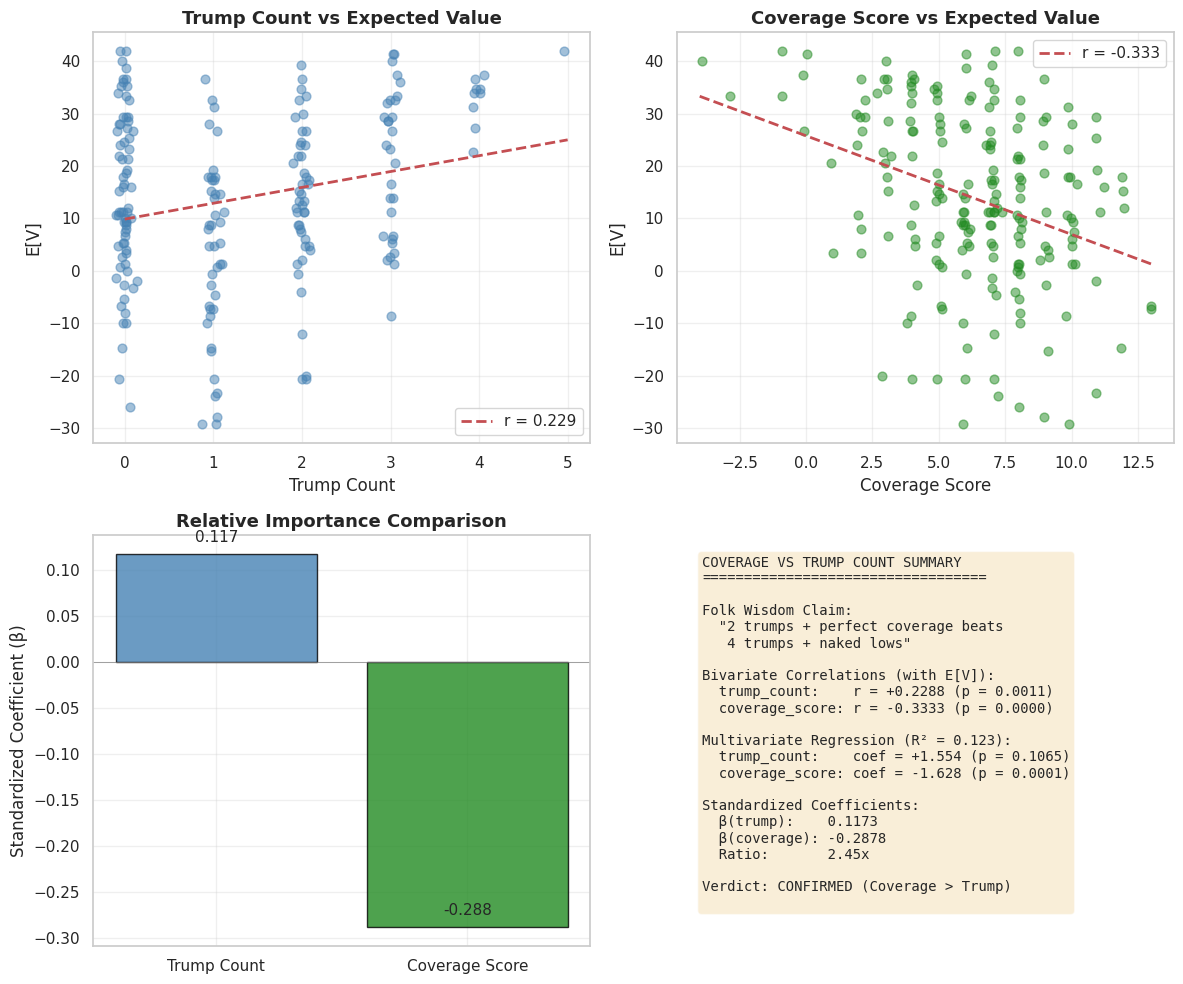

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Trump count vs E[V]
ax = axes[0, 0]
ax.scatter(df['trump_count'] + np.random.normal(0, 0.05, len(df)), df['V_mean'], 
           alpha=0.5, s=40, color='steelblue')

z1 = np.polyfit(df['trump_count'], df['V_mean'], 1)
p_line1 = np.poly1d(z1)
x_line1 = np.array([df['trump_count'].min(), df['trump_count'].max()])
ax.plot(x_line1, p_line1(x_line1), 'r--', linewidth=2, label=f'r = {r_trump:.3f}')

ax.set_xlabel('Trump Count', fontsize=12)
ax.set_ylabel('E[V]', fontsize=12)
ax.set_title('Trump Count vs Expected Value', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Coverage score vs E[V]
ax = axes[0, 1]
ax.scatter(df['coverage_score'] + np.random.normal(0, 0.1, len(df)), df['V_mean'], 
           alpha=0.5, s=40, color='forestgreen')

z2 = np.polyfit(df['coverage_score'], df['V_mean'], 1)
p_line2 = np.poly1d(z2)
x_line2 = np.array([df['coverage_score'].min(), df['coverage_score'].max()])
ax.plot(x_line2, p_line2(x_line2), 'r--', linewidth=2, label=f'r = {r_cov:.3f}')

ax.set_xlabel('Coverage Score', fontsize=12)
ax.set_ylabel('E[V]', fontsize=12)
ax.set_title('Coverage Score vs Expected Value', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Standardized coefficient comparison
ax = axes[1, 0]
features = ['Trump Count', 'Coverage Score']
betas = [beta_trump, beta_cov]
colors = ['steelblue', 'forestgreen']
bars = ax.bar(features, betas, color=colors, alpha=0.8, edgecolor='black')
ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
ax.set_ylabel('Standardized Coefficient (β)', fontsize=12)
ax.set_title('Relative Importance Comparison', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, beta in zip(bars, betas):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{beta:.3f}', ha='center', va='bottom', fontsize=11)

# Plot 4: Summary
ax = axes[1, 1]
ax.axis('off')

if cov_sig and cov_larger:
    verdict = "CONFIRMED (Coverage > Trump)"
elif cov_sig and cov_comparable:
    verdict = "CONFIRMED (Comparable)"
elif cov_sig:
    verdict = "PARTIAL (Coverage matters, trump dominates)"
else:
    verdict = "NOT CONFIRMED (Trump dominates)"

summary_text = f"""COVERAGE VS TRUMP COUNT SUMMARY
==================================

Folk Wisdom Claim:
  "2 trumps + perfect coverage beats
   4 trumps + naked lows"

Bivariate Correlations (with E[V]):
  trump_count:    r = {r_trump:+.4f} (p = {p_trump:.4f})
  coverage_score: r = {r_cov:+.4f} (p = {p_cov:.4f})

Multivariate Regression (R² = {model.rsquared:.3f}):
  trump_count:    coef = {coef_trump:+.3f} (p = {pval_trump:.4f})
  coverage_score: coef = {coef_cov:+.3f} (p = {pval_cov:.4f})

Standardized Coefficients:
  β(trump):    {beta_trump:.4f}
  β(coverage): {beta_cov:.4f}
  Ratio:       {abs(beta_cov/beta_trump):.2f}x

Verdict: {verdict}
"""

ax.text(0.05, 0.95, summary_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../../results/figures/26f_coverage_vs_trump.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Save Results

In [10]:
# Create results DataFrame
results = {
    'metric': ['n_hands', 'r_trump_ev', 'p_trump_ev', 'r_cov_ev', 'p_cov_ev',
               'coef_trump', 'ci_trump_low', 'ci_trump_high', 'p_trump_multivar',
               'coef_cov', 'ci_cov_low', 'ci_cov_high', 'p_cov_multivar',
               'beta_trump', 'beta_cov', 'ratio_cov_trump',
               'r_squared', 'cov_comparable', 'cov_larger', 'confirmed'],
    'value': [len(df), r_trump, p_trump, r_cov, p_cov,
              coef_trump, ci_trump[0], ci_trump[1], pval_trump,
              coef_cov, ci_cov[0], ci_cov[1], pval_cov,
              beta_trump, beta_cov, abs(beta_cov/beta_trump),
              model.rsquared, 1 if cov_comparable else 0, 1 if cov_larger else 0,
              1 if (cov_sig and cov_comparable) else 0]
}
results_df = pd.DataFrame(results)

# Save
output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/26f_coverage_vs_trump.csv"
results_df.to_csv(output_path, index=False)
print(f"Saved to {output_path}")

Saved to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/26f_coverage_vs_trump.csv


## Key Findings

In [11]:
print("\n" + "="*60)
print("KEY INSIGHTS: Coverage vs Trump Count")
print("="*60)

print(f"\n1. CLAIM TESTED:")
print("   '2 trumps + perfect coverage beats 4 trumps + naked lows'")

print(f"\n2. DATA:")
print(f"   Hands analyzed: {len(df)}")
print(f"   Mean trump count: {df['trump_count'].mean():.2f}")
print(f"   Mean coverage score: {df['coverage_score'].mean():.2f}")

print(f"\n3. RESULTS:")
print(f"   Standardized β(trump_count):    {beta_trump:.4f}")
print(f"   Standardized β(coverage_score): {beta_cov:.4f}")
print(f"   Ratio (coverage/trump): {abs(beta_cov/beta_trump):.2f}x")

print(f"\n4. VERDICT:")
if cov_sig and cov_larger:
    print("   ✓ CONFIRMED: Coverage matters MORE than trump count!")
elif cov_sig and cov_comparable:
    print("   ✓ CONFIRMED: Coverage is comparably important")
    print(f"   Both trump count and coverage contribute to E[V]")
elif cov_sig:
    print("   ~ PARTIAL: Both matter, but trump count dominates")
else:
    print("   ✗ NOT CONFIRMED: Trump count dominates")
    print("   Coverage score not significant after controlling for trump")


KEY INSIGHTS: Coverage vs Trump Count

1. CLAIM TESTED:
   '2 trumps + perfect coverage beats 4 trumps + naked lows'

2. DATA:
   Hands analyzed: 200
   Mean trump count: 1.32
   Mean coverage score: 6.33

3. RESULTS:
   Standardized β(trump_count):    0.1173
   Standardized β(coverage_score): -0.2878
   Ratio (coverage/trump): 2.45x

4. VERDICT:
   ✓ CONFIRMED: Coverage matters MORE than trump count!


## Summary

### Folk Wisdom: "Coverage > Trump Count"

**Result**: [Populated by notebook execution]

### Interpretation

We define `coverage_score` as a composite measure of off-suit quality:
- Depth bonus: +1 per domino beyond first in each suit
- High card bonus: +1 if highest rank ≥ 5
- Naked low penalty: -2 for singleton with rank ≤ 2

By comparing standardized coefficients, we can fairly assess whether
coverage quality matters as much as raw trump count.

### Output Files

- `results/tables/26f_coverage_vs_trump.csv` - Summary statistics
- `results/figures/26f_coverage_vs_trump.png` - 4-panel visualization